[API Design &lt;](APIs.ipynb) | [&gt; Use of Special Features](Magic.ipynb)

# Use of AWS in Jupyter Notebooks

## Results Summary:

- Only half a percent of notebooks import at least one of sagemaker, boto, or mxnet. This breaks down to 0.11% importing Sagemaker, 0.2% Boto, 0.29% MXNet, and some notebooks importing more than one.
- There is a moderate positive correlation between the use of Sagemaker and Boto (r = 0.49), but the use MXNet is independent of both (MXNet and Sagemaker r = 0.03, MXNet and Boto3 r = 0.02).
- Within Boto, the most frequent uses are regioninfo and mrturk. More specifically, the most frequent uses of Boto3 are clients, sessions, and resources. S3 is the most commonly used Boto resource and client. The next most popular client is Sagemaker.
- Sagemaker is most frequently used for get_execution_role, amazon, predictor, and Session.
- The MXNet package is most frequently used for gluon, symbol, and nd. 

---


# Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

import load_data

Load dataframes

In [2]:
notebooks_temp = load_data.load_notebooks()
repos_temp = load_data.load_repos()

Notebooks loaded in 0:00:24.942097
Repos loaded in 0:00:04.118985


Load aggregated dataframes. Code used to create them is in [aggregate.py](aggregate.py).

In [3]:
nb_code_df_temp = load_data.load_code()
nb_imports_df_temp = load_data.load_nb_imports()

Code loaded in 0:01:21.626657
Notebook imports loaded in 0:01:18.590318


### Python notebooks

In [4]:
notebooks = notebooks_temp.copy()[notebooks_temp.lang_name == 'python']
repos = repos_temp.copy()[repos_temp.repo_id.isin(notebooks.repo_id)]

In [5]:
nb_code_df = nb_code_df_temp[nb_code_df_temp.file.isin(notebooks.file)]
nb_imports_df = nb_imports_df_temp[nb_imports_df_temp.file.isin(notebooks.file)]

In [6]:
del nb_code_df_temp
del nb_imports_df_temp
del notebooks_temp
del repos_temp

---
# Manipulate Data

Add code to imports dataframe.

In [7]:
nb_imports_code_df = nb_code_df.merge(nb_imports_df, on = 'file')

Add import of sagemaker, boto, and mxnet to imports dataframe.

In [8]:
start = datetime.datetime.now()
for package in ['sagemaker', 'mxnet']:
    if package not in nb_imports_code_df.columns:
        nb_imports_code_df[package] = [package in [i[0].split('.')[0] for i in im] for im in nb_imports_code_df.imports]
        print(package, datetime.datetime.now() - start)
if 'boto' not in nb_imports_code_df.columns:
    nb_imports_code_df['boto'] = [
        'boto' in [i[0].split('.')[0] for i in im] or 
        'boto3' in [i[0].split('.')[0] for i in im] or
        'botocore' in [i[0].split('.')[0] for i in im]
        for im in nb_imports_code_df.imports
    ]
    print('boto', datetime.datetime.now() - start)
end = datetime.datetime.now()
print(end - start)

sagemaker 0:00:16.414791
mxnet 0:00:32.996071
boto 0:01:15.720805
0:01:15.721369


---
# Visualizations and Statistics

In [9]:
print("{0}% of notebooks import sagemaker.".format(
    round(100*sum(nb_imports_code_df.sagemaker)/len(nb_imports_code_df),2)
))
print("{0}% of notebooks import boto.".format(
    round(100*sum(nb_imports_code_df.boto)/len(nb_imports_code_df),2)
))
print("{0}% of notebooks import mxnet.".format(
    round(100*sum(nb_imports_code_df.mxnet)/len(nb_imports_code_df),2)
))
print("\n{0}% of notebooks import at least one of sagemaker, boto3, or mxnet.".format(
    round(100*sum(nb_imports_code_df.sagemaker|nb_imports_code_df.boto|nb_imports_code_df.mxnet)/len(nb_imports_code_df),2)
))


0.11% of notebooks import sagemaker.
0.2% of notebooks import boto.
0.29% of notebooks import mxnet.

0.52% of notebooks import at least one of sagemaker, boto3, or mxnet.


Boto is imported almost twice as frequently as sagemaker. Mxnet is almost three times as frequently as sagemaker.

In [10]:
aws_imports = nb_imports_code_df.copy()[
    nb_imports_code_df.sagemaker|nb_imports_code_df.boto|nb_imports_code_df.mxnet
].reset_index(drop=True)

### Imports
Replace aliases in code with actual package names.

In [11]:
def replace_aliases(code, imports):
    updated_code = []
    for cell in code:
        if str(cell) != 'nan':
            for im in [i for i in imports if i[0].startswith('boto') or
             i[0].startswith('sagemaker') or i[0].startswith('mxnet')
            ]:
                cell = re.sub('(?<![a-zA-Z\._]){0}'.format(im[1]), im[0], cell)
            updated_code.append(cell)
    return updated_code

In [12]:
# 15 seconds
start = datetime.datetime.now()
new = []
for i in range(len(aws_imports)):
    new.append(replace_aliases(aws_imports.code[i], aws_imports.imports[i]))
    if i%1000 == 0:
        print(i, end = ' ')
aws_imports['code'] = new
end = datetime.datetime.now()
print(end - start)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 0:02:09.232422


In [13]:
# 6 minutes
start = datetime.datetime.now()
aws_imports['boto_uses'] = [
    [l[0] for l in 
     list(re.findall(
         '(?<![a-zA-Z_\.0-9])(boto(core|3)?\.[a-zA-Z_0-9\.]+)', 
         ' '.join([c for c in code if str(c) != 'nan'])
    ))] 
    for code in aws_imports.code
]
print('boto', datetime.datetime.now() - start)

aws_imports['create_training_job'] = [
    list(re.findall(
        '[a-zA-Z0-9_\.]+\.create_training_job\(', 
        ' '.join([c for c in code if str(c) != 'nan'])
    )) 
    for code in aws_imports.code
]
print('create_training_job', datetime.datetime.now() - start)

aws_imports['fit'] = [
    list(re.findall(
        '[a-zA-Z0-9_\.]+\.fit\(', 
        ' '.join([c for c in code if str(c) != 'nan'])
    )) + list(re.findall(
        '[a-zA-Z0-9_\.]+\.fit_generator\(', 
        ' '.join([c for c in code if str(c) != 'nan'])
    )) 
    for code in aws_imports.code
]
print('fit', datetime.datetime.now() - start)

aws_imports['sagemaker_uses'] = [
    list(re.findall(
        '(?<![a-zA-Z_\.0-9])sagemaker\.[a-zA-Z_0-9\.]+', 
        ' '.join([c for c in code if str(c) != 'nan'])
    )) 
    for code in aws_imports.code
]
print('sagemaker', datetime.datetime.now() - start)

aws_imports['mxnet_uses'] = [
    list(re.findall(
        '(?<![a-zA-Z_\.0-9])mxnet\.[a-zA-Z_0-9\.]+',
        ' '.join([c for c in code if str(c) != 'nan'])
    )) 
    for code in aws_imports.code
]
print('mxnet', datetime.datetime.now() - start)


boto 0:00:30.547394
create_training_job 0:01:57.655204
fit 0:04:50.606393
sagemaker 0:05:19.896821
mxnet 0:05:49.174968


## Boto

### Uses

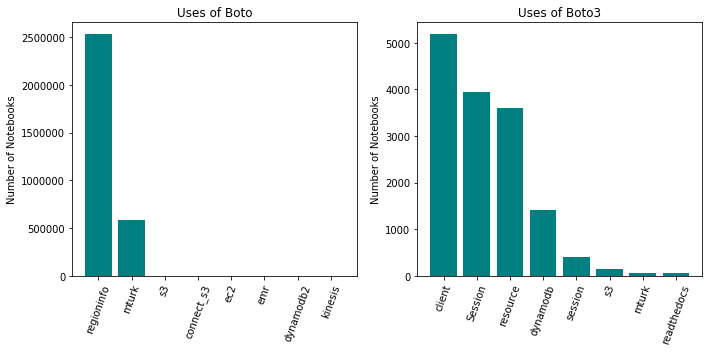

In [17]:
boto_counts = pd.Series([b.split('.')[1] for b in load_data.flatten(aws_imports.boto_uses) if not b.startswith('boto3') and not b.startswith('botocore')]).value_counts().reset_index().rename(columns={'index':'use', 0:'num'})
boto3_counts = pd.Series([b.split('.')[1] for b in load_data.flatten(aws_imports.boto_uses) if b.startswith('boto3')]).value_counts().reset_index().rename(columns={'index':'use', 0:'num'})


fig = plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
x = boto_counts[boto_counts.num > 30].use[:10]
x_pos = np.arange(len(x))
y = boto_counts[boto_counts.num > 30].num[:10]
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.title('Uses of Boto')
plt.ylabel('Number of Notebooks')

plt.subplot(1,2,2)
x = boto3_counts[boto3_counts.num > 30].use[:10]
x_pos = np.arange(len(x))
y = boto3_counts[boto3_counts.num > 30].num[:10]
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.title('Uses of Boto3')
plt.ylabel('Number of Notebooks')

plt.tight_layout()
plt.show()

What Clients and Resources are used the most?

In [18]:
# 1 minute
start = datetime.datetime.now()

aws_imports['boto_resource_use'] = [[x[0].split('(')[1].strip().replace('"','').replace("'","")
    for x in list(re.findall('(?<![a-zA-Z_\.0-9])(boto(core|3)?\.resource[a-zA-Z_0-9\.\(\s\'"]+)', ' '.join(
        [c for c in code if str(c) != 'nan']
    ))) if '(' in x[0]] for code in aws_imports.code
]
print('resource', datetime.datetime.now() - start)

aws_imports['boto_client_use'] = [[x[0].split('(')[1].strip().replace('"','').replace("'","")
    for x in list(re.findall('(?<![a-zA-Z_\.0-9])(boto(core|3)?\.client[a-zA-Z_0-9\.\(\s\'"]+)', ' '.join(
        [c for c in code if str(c) != 'nan']
    ))) if '(' in x[0]] for code in aws_imports.code
]

print('client', datetime.datetime.now() - start)

resource 0:00:29.986658
client 0:00:59.954437


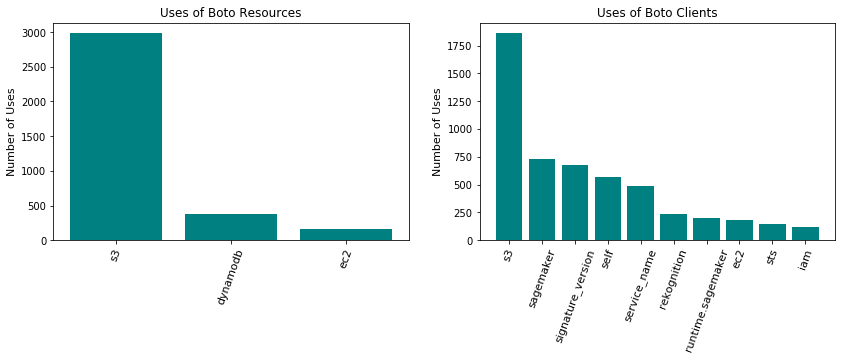

In [19]:
fig = plt.figure(figsize = (14, 4))
plt.subplot(1,2,1)
resource_counts = pd.Series(load_data.flatten(aws_imports['boto_resource_use'])).value_counts().reset_index().rename(columns = {'index':'use',0:'num'})
x = resource_counts[resource_counts.num > 100].use
x_pos = np.arange(len(x))
y = resource_counts[resource_counts.num > 100].num
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70, fontsize = 11)
plt.title('Uses of Boto Resources', fontsize = 12)
plt.ylabel('Number of Uses', fontsize = 11)

plt.subplot(1,2,2)
client_counts = pd.Series(load_data.flatten(aws_imports['boto_client_use'])).value_counts().reset_index().rename(columns = {'index':'use',0:'num'})
x = client_counts[client_counts.num > 100].use
x_pos = np.arange(len(x))
y = client_counts[client_counts.num > 100].num
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70, fontsize = 11)
plt.title('Uses of Boto Clients', fontsize = 12)
plt.ylabel('Number of Uses', fontsize = 11)
plt.show()

#### Use of 'create_training_job' versus training regularly in the notebook.

In [20]:
print("{0}% of notebooks that use boto call a function called create_training_job.".format(
    round(100*sum([len(t) > 0 for t in aws_imports['create_training_job']]&aws_imports['boto']) / sum(aws_imports['boto']), 3)
))
print("{0}% of notebooks that use boto call a function called fit.".format(
    round(100*sum([len(t) > 0 for t in aws_imports['fit']]&aws_imports['boto']) / sum(aws_imports['boto']), 3)
))
print("{0}% of notebooks that use boto call both.".format(
    round(100*sum([len(t) > 0 for t in aws_imports['create_training_job']]&(
        [len(t) > 0 for t in aws_imports['fit']]&aws_imports['boto'])
    ) / sum(aws_imports['boto']), 3)
))

5.32% of notebooks that use boto call a function called create_training_job.
35.658% of notebooks that use boto call a function called fit.
0.253% of notebooks that use boto call both.


In [21]:
print("{0}% of notebooks that use the sagemaker client in boto call a function called create_training_job.".format(
    round(100*sum((
            [len(t) > 0 for t in aws_imports['create_training_job']]
            &aws_imports['boto']
            &['sagemaker' in a for a in aws_imports['boto_client_use']]
        )) / sum((aws_imports['boto']
                  &['sagemaker' in a for a in aws_imports['boto_client_use']]
        )), 3)
))
print("{0}% of notebooks that use the sagemaker client in  boto call a function called fit.".format(
    round(100*sum((
        [len(t) > 0 for t in aws_imports['fit']]
        &aws_imports['boto']
        &['sagemaker' in a for a in aws_imports['boto_client_use']]
        )) / sum((aws_imports['boto']
              &['sagemaker' in a for a in aws_imports['boto_client_use']]
        )), 3)
))
print("{0}% of notebooks that use the sagemaker client in boto call both.".format(
    round(100*sum((pd.Series([len(t) > 0 for t in aws_imports['create_training_job']])
                   &[len(t) > 0 for t in aws_imports['fit']]&aws_imports['boto']&['sagemaker' in a for a in aws_imports['boto_client_use']])
    ) / sum(aws_imports['boto']&['sagemaker' in a for a in aws_imports['boto_client_use']]), 3)
))

47.432% of notebooks that use the sagemaker client in boto call a function called create_training_job.
41.952% of notebooks that use the sagemaker client in  boto call a function called fit.
2.911% of notebooks that use the sagemaker client in boto call both.


##  Uses of Sagemaker

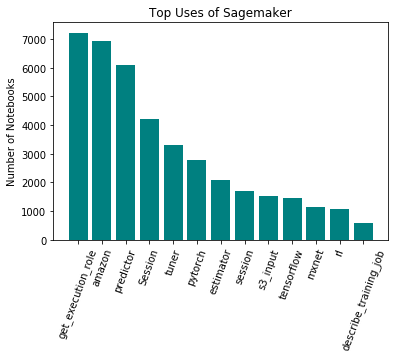

In [22]:
sagemaker_counts = pd.Series([
    s.split('.')[1] for s in load_data.flatten(aws_imports.sagemaker_uses) if '.' in s
]).value_counts().reset_index().rename(columns={'index':'use', 0:'num'})
x = sagemaker_counts[sagemaker_counts.num > 500].use
x_pos = np.arange(len(x))
y = sagemaker_counts[sagemaker_counts.num > 500].num
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.title('Top Uses of Sagemaker')
plt.ylabel('Number of Notebooks')
plt.show()

### Over Time

In [23]:
aws_imports_dates = aws_imports.merge(notebooks[['file','repo_id']], on = 'file').merge(repos[['repo_id','pushed_at']], on = 'repo_id')
aws_imports_dates['pushed_at'] = pd.to_datetime(aws_imports_dates['pushed_at'])
aws_imports_dates['month'] = [p.month for p in aws_imports_dates['pushed_at']]
aws_imports_dates['year'] = [p.year for p in aws_imports_dates['pushed_at']]

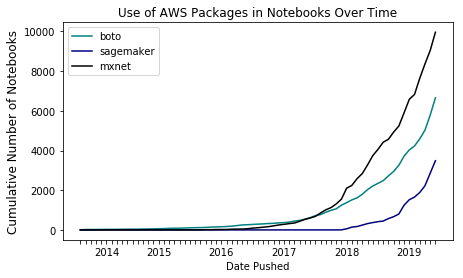

In [24]:
aws_imports_over_time = aws_imports_dates.groupby(['year', 'month'])[['boto','sagemaker','mxnet']].aggregate(lambda x: sum(x)).reset_index()

july_19_idx = aws_imports_over_time[(aws_imports_over_time.year==2019)&(aws_imports_over_time.month==7)].index.values[0]
aws_imports_over_time = aws_imports_over_time[:july_19_idx]

aws_imports_over_time['order'] = range(len(aws_imports_over_time))
aws_imports_over_time['label'] = [str(r.year) if r.month == 1 else '' for _, r in aws_imports_over_time.iterrows()]

fig = plt.figure(figsize = (7, 4))
x = aws_imports_over_time.order
y1 = aws_imports_over_time.boto.cumsum()
y2 = aws_imports_over_time.sagemaker.cumsum()
y3 = aws_imports_over_time.mxnet.cumsum()

plt.plot(x, y1, color = 'teal', label = 'boto')
plt.plot(x, y2, color = 'navy', label = 'sagemaker')
plt.plot(x, y3, color = 'black', label = 'mxnet')

plt.xticks(x, aws_imports_over_time.label)
plt.xlabel('Date Pushed')
plt.ylabel('Cumulative Number of Notebooks', fontsize = 12)
plt.title('Use of AWS Packages in Notebooks Over Time', fontsize = 12)
plt.legend()
plt.show()

## Use of MXNet

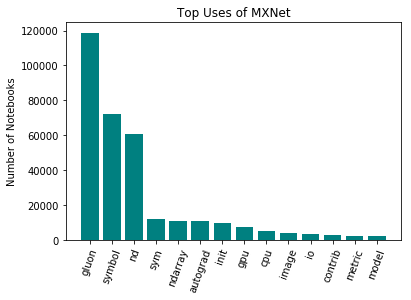

In [25]:
mxnet_counts = pd.Series([s.split('.')[1] for s in load_data.flatten(aws_imports.mxnet_uses)]).value_counts().reset_index().rename(columns={'index':'use', 0:'num'})
x = mxnet_counts[mxnet_counts.num > 2000].use
x_pos = np.arange(len(x))
y = mxnet_counts[mxnet_counts.num > 2000].num
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.title('Top Uses of MXNet')
plt.ylabel('Number of Notebooks')
plt.show()

In [26]:
print("Pr(mxnet) = {0}".format(
    round(
        sum(nb_imports_code_df.mxnet) / len(nb_imports_code_df),
        3
    )
))
print("Pr(mxnet|boto3) = {0}".format(
    round(
        sum(nb_imports_code_df.mxnet&nb_imports_code_df.boto) / sum(nb_imports_code_df.boto),
        3
    )
))
print("Pr(mxnet|sagemaker) = {0}".format(
    round(
        sum(nb_imports_code_df.mxnet&nb_imports_code_df.sagemaker) / sum(nb_imports_code_df.sagemaker),
        3
    )
))

Pr(mxnet) = 0.003
Pr(mxnet|boto3) = 0.029
Pr(mxnet|sagemaker) = 0.055


In [27]:
nb_imports_code_df[['sagemaker','boto','mxnet']].corr()

,sagemaker,boto,mxnet
sagemaker,1.000000,0.466465,0.032067
boto,0.466465,1.000000,0.021538
mxnet,0.032067,0.021538,1.000000


Under hypothesis that sagemaker and boto3 are associated but mxnet is independent from both, the ratio of determinants of the entire correlation matrix should be equal to that of the correlation matrix where $r_{mxnet, sagemaker}$ = $r_{mxnet, boto3}$ = 0. Thus the ratio of determinants should be close to 1.

In [28]:
(np.linalg.det(nb_imports_code_df[['sagemaker','boto','mxnet']].corr()) /
np.linalg.det(nb_imports_code_df[['sagemaker','boto']].corr()))

0.9989163471120691

Very close to 1. It's likely that the use of mxnet is independent from that of boto3 and sagemaker while the boto3 and sagemaker are associated.

[API Design &lt;](APIs.ipynb) | [&gt; Use of Special Features](Magic.ipynb)